# 0. Importação das bibliotecas necessárias

In [27]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dropout, Dense, Flatten, InputLayer
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# 1. Carregamento e preparação dos dados

In [17]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# normalização dos dados
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# OneHotEncoding dos rótulos
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

In [18]:
print(f"Dataset de treino {train_images.shape}")
print(f"Dataset de teste {test_images.shape}")

print(f"Rótulos de treino {train_labels.shape}")
print(f"Rótulos de teste {test_labels.shape}")

Dataset de treino (50000, 32, 32, 3)
Dataset de teste (10000, 32, 32, 3)
Rótulos de treino (50000, 10)
Rótulos de teste (10000, 10)


# 2. Data augmentation

In [19]:
# aplicando flip, rotação e zoom
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1)
])

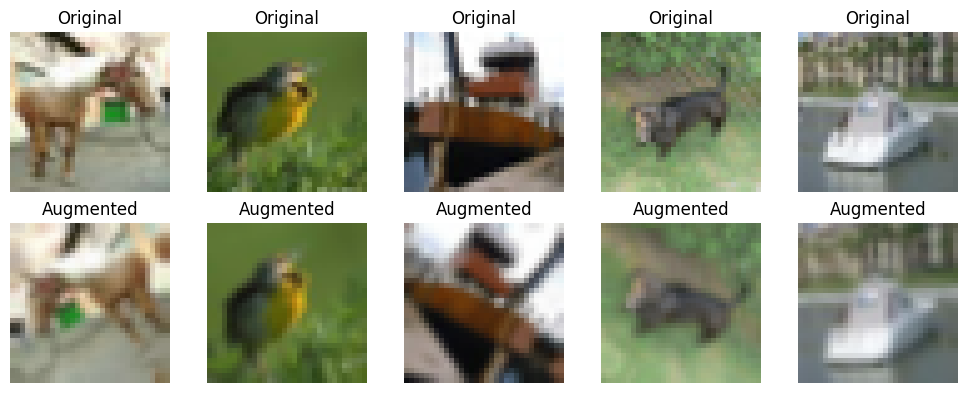

In [20]:
num_images_to_show = 5
indices = np.random.choice(np.arange(len(train_images)), size=num_images_to_show, replace=False)
sample_images = train_images[indices]

augmented_images = data_augmentation(sample_images)

plt.figure(figsize=(10, 4))
for i in range(num_images_to_show):
    ax = plt.subplot(2, num_images_to_show, i + 1)
    plt.imshow(sample_images[i])
    plt.title("Original")
    plt.axis("off")

    ax = plt.subplot(2, num_images_to_show, i + 1 + num_images_to_show)
    plt.imshow(augmented_images[i])
    plt.title("Augmented")
    plt.axis("off")

plt.tight_layout()
plt.show()

# 3. Definição do modelo

In [30]:
model = Sequential([
    InputLayer(input_shape=(32, 32, 3)),
    data_augmentation,
    Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)),
    ReLU(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), padding='same'),
    ReLU(),
    MaxPooling2D((2, 2)),
    Dropout(0.2), #técnica de regularização usada para prevenir o overfitting, por meio do descarte aleatório de neurônios
                  #durante o treinamento, forçando o modelo a aprender padrões mais generalizados nos dados.

    Conv2D(128, (3, 3), padding='same'),
    ReLU(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 re_lu_18 (ReLU)             (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 re_lu_19 (ReLU)             (None, 16, 16, 64)        0         
                                                      

# 4. Configuração do Early Stopping

In [31]:
# configuração do EarlyStopping para interromper o treinamento quando não houver melhoria no val_loss
# após um número definido de épocas (patience), e restaurar os pesos do melhor modelo obtido
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# 5. Treinamento do modelo

In [32]:
history = model.fit(
    train_images,
    train_labels,
    epochs=100,
    validation_split=0.2,
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/100
625/625 [==============================] - 125s 197ms/step - loss: 1.8082 - accuracy: 0.3352 - val_loss: 1.5144 - val_accuracy: 0.4473
Epoch 2/100
625/625 [==============================] - 108s 173ms/step - loss: 1.5218 - accuracy: 0.4509 - val_loss: 1.3654 - val_accuracy: 0.5147
Epoch 3/100
625/625 [==============================] - 133s 213ms/step - loss: 1.4112 - accuracy: 0.4913 - val_loss: 1.2146 - val_accuracy: 0.5626
Epoch 4/100
625/625 [==============================] - 103s 164ms/step - loss: 1.3358 - accuracy: 0.5204 - val_loss: 1.1886 - val_accuracy: 0.5814
Epoch 5/100
625/625 [==============================] - 107s 172ms/step - loss: 1.2812 - accuracy: 0.5440 - val_loss: 1.1381 - val_accuracy: 0.6030
Epoch 6/100
625/625 [==============================] - 100s 159ms/step - loss: 1.2337 - accuracy: 0.5617 - val_loss: 1.0583 - val_accuracy: 0.6165
Epoch 7/100
625/625 [==============================] - 104s 166ms/step - loss: 1.1953 - accuracy: 0.5809 - val_loss: 0

# 6. Visualizando função de perda e acurácia ao longo das épocas

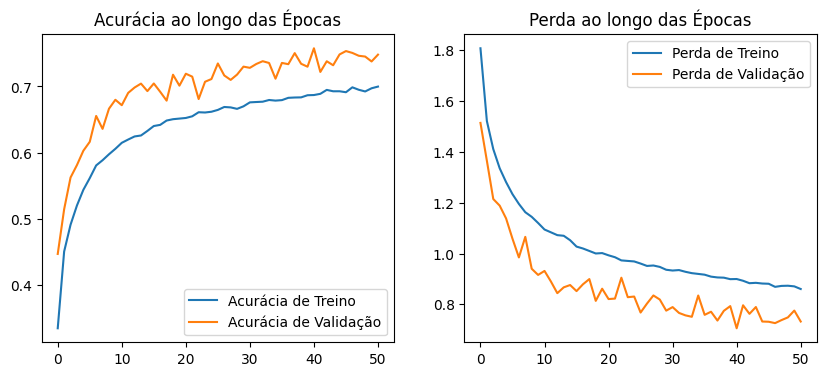

In [33]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia de Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia ao longo das Épocas')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perda de Treino')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda ao longo das Épocas')
plt.legend()
plt.show()

## 6.1 Acurácia final do modelo

In [34]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Acurácia no teste: {test_acc}')

313/313 [==============================] - 6s 20ms/step - loss: 0.7091 - accuracy: 0.7502
Acurácia no teste: 0.7501999735832214


# 7.Realizando e visualizando predições

In [35]:
def plot_image(predictions_array, true_label, img):
    true_label, img = int(true_label), img
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]),
                                         color=color)

def display_prediction(images, labels, predictions):
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(predictions[i], labels[i], images[i])
    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 153ms/step


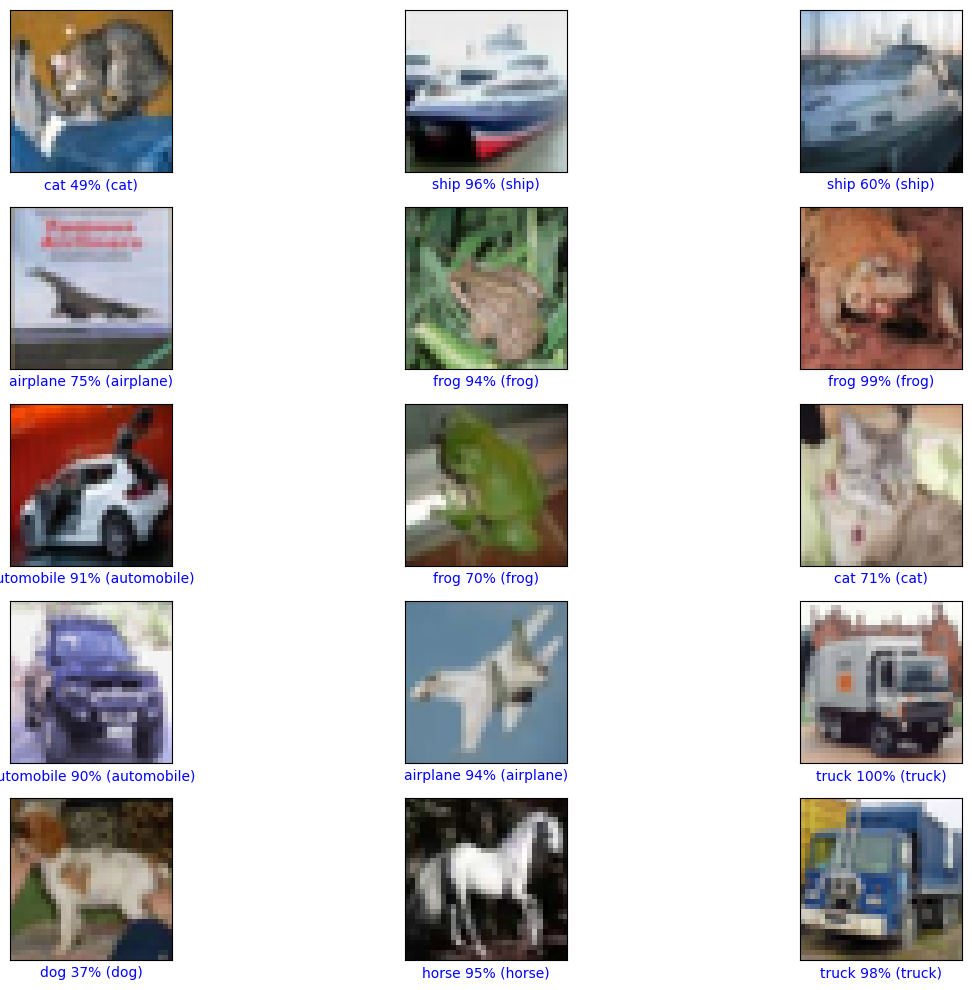

In [36]:
test_images, test_labels = test_images[:15], np.argmax(test_labels[:15], axis=1)
predictions = model.predict(test_images)
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
display_prediction(test_images, test_labels, predictions)

# 8. Salvando .h5 do modelo

In [38]:
model.save('modelo_h5_ponderada_sem6_allan_casado.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 9. Quantização do modelo

A quantização do modelo serve para reduzir o tamanho do arquivo do modelo, deixando ele mais leve, mas mantendo um desempenho aceitável. A quantização reduz a precisão dos números usados no modelo de 32 bits (float) para 8 bits (int). Isso não só diminui o tamanho do modelo, como também pode acelerar a inferência, dependendo do ambiente de execução.



In [37]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_quant_model = converter.convert()

with open('modelo_quantizado_ponderada_sem6_allan_casado.tflite', 'wb') as f:
    f.write(tflite_quant_model)